# Digits generator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Visualisation

In [4]:
def reshape_image(pixels):
    npix = int(np.sqrt(pixels.shape[0]))
    return np.reshape(pixels, (npix, npix))

def draw_image(image):
    image = np.reshape(image, (image.shape[0], image.shape[1]))
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [5]:
# draw_image(reshape_image(mnist.train.images[0]))

In [6]:
X_train = mnist.train.images.reshape(-1,  
                                     28, 
                                     28, 
                                     1).astype(np.float32)
y_train = mnist.train.labels

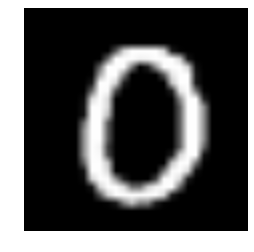

(None, array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [7]:
draw_image(X_train[10]), y_train[10]

In [8]:
X_train.shape

(55000, 28, 28, 1)

# GAN example
## Generator

In [9]:
gen_dropout = 0.3
gen_input_dim = 7
gen_depth = 256
gen_noise_dim = 100

In [10]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('sigmoid'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## Discriminator

In [11]:
disc_depth = 64
disc_dropout = 0.3

In [12]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(28, 28, 1), 
                   padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

## Discriminator model

In [13]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [14]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [15]:
batch_size = 256
train_iters = 1000

disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

for i in range(train_iters):
    # Get random real images
    images_true = X_train[np.random.randint(0, 
                                            X_train.shape[0], 
                                            size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(dics_loss[0])
    disc_losses["acc"].append(dics_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Print results
    print("{}th batch of {} |Disc loss {} |Disc acc {} |Adv loss {} |Adv acc {}".format(i+1, train_iters,
                                                                                       dics_loss[0], dics_loss[1], 
                                                                                       adv_loss[0], adv_loss[1]))

1th batch of 1000 |Disc loss 0.6942058205604553 |Disc acc 0.4375 |Adv loss 0.8159822225570679 |Adv acc 0.0
2th batch of 1000 |Disc loss 0.6656507849693298 |Disc acc 0.5 |Adv loss 0.8056319952011108 |Adv acc 0.0
3th batch of 1000 |Disc loss 0.5532829165458679 |Disc acc 0.9765625 |Adv loss 0.766473114490509 |Adv acc 0.03515625
4th batch of 1000 |Disc loss 0.5338043570518494 |Disc acc 0.5 |Adv loss 1.1766403913497925 |Adv acc 0.0
5th batch of 1000 |Disc loss 0.44686102867126465 |Disc acc 0.98828125 |Adv loss 0.6356590986251831 |Adv acc 0.83203125
6th batch of 1000 |Disc loss 0.21888138353824615 |Disc acc 1.0 |Adv loss 0.31712162494659424 |Adv acc 1.0
7th batch of 1000 |Disc loss 0.18258340656757355 |Disc acc 1.0 |Adv loss 0.47408270835876465 |Adv acc 0.98828125
8th batch of 1000 |Disc loss 0.110439732670784 |Disc acc 1.0 |Adv loss 0.16241368651390076 |Adv acc 1.0
9th batch of 1000 |Disc loss 0.04697813093662262 |Disc acc 1.0 |Adv loss 0.056393057107925415 |Adv acc 1.0
10th batch of 1000 |

75th batch of 1000 |Disc loss 0.4626132845878601 |Disc acc 0.833984375 |Adv loss 0.7033514976501465 |Adv acc 0.49609375
76th batch of 1000 |Disc loss 0.7473028302192688 |Disc acc 0.521484375 |Adv loss 2.116180896759033 |Adv acc 0.0
77th batch of 1000 |Disc loss 0.43333059549331665 |Disc acc 0.85546875 |Adv loss 0.8824405670166016 |Adv acc 0.265625
78th batch of 1000 |Disc loss 0.6772347092628479 |Disc acc 0.509765625 |Adv loss 2.2715697288513184 |Adv acc 0.0
79th batch of 1000 |Disc loss 0.4248172342777252 |Disc acc 0.875 |Adv loss 0.8546379804611206 |Adv acc 0.2578125
80th batch of 1000 |Disc loss 0.704775333404541 |Disc acc 0.509765625 |Adv loss 2.260404348373413 |Adv acc 0.0
81th batch of 1000 |Disc loss 0.4432038962841034 |Disc acc 0.8828125 |Adv loss 0.7564196586608887 |Adv acc 0.44921875
82th batch of 1000 |Disc loss 0.74723881483078 |Disc acc 0.515625 |Adv loss 2.270933151245117 |Adv acc 0.0
83th batch of 1000 |Disc loss 0.40853002667427063 |Disc acc 0.908203125 |Adv loss 0.7807

148th batch of 1000 |Disc loss 0.7766063213348389 |Disc acc 0.5 |Adv loss 1.5914424657821655 |Adv acc 0.0
149th batch of 1000 |Disc loss 0.5440637469291687 |Disc acc 0.90234375 |Adv loss 0.7552745938301086 |Adv acc 0.32421875
150th batch of 1000 |Disc loss 0.7052438259124756 |Disc acc 0.501953125 |Adv loss 1.5538069009780884 |Adv acc 0.0
151th batch of 1000 |Disc loss 0.5539229512214661 |Disc acc 0.884765625 |Adv loss 0.7961941957473755 |Adv acc 0.21484375
152th batch of 1000 |Disc loss 0.6916422843933105 |Disc acc 0.5 |Adv loss 1.683374285697937 |Adv acc 0.0
153th batch of 1000 |Disc loss 0.5400812029838562 |Disc acc 0.890625 |Adv loss 0.7374253869056702 |Adv acc 0.3671875
154th batch of 1000 |Disc loss 0.7358036041259766 |Disc acc 0.5 |Adv loss 1.7770752906799316 |Adv acc 0.0
155th batch of 1000 |Disc loss 0.566999614238739 |Disc acc 0.7734375 |Adv loss 0.5679224133491516 |Adv acc 0.8359375
156th batch of 1000 |Disc loss 0.7743213176727295 |Disc acc 0.5 |Adv loss 1.461269736289978 |A

220th batch of 1000 |Disc loss 0.7357948422431946 |Disc acc 0.5 |Adv loss 1.8265445232391357 |Adv acc 0.0
221th batch of 1000 |Disc loss 0.6250399947166443 |Disc acc 0.57421875 |Adv loss 0.45982295274734497 |Adv acc 0.98828125
222th batch of 1000 |Disc loss 0.7918026447296143 |Disc acc 0.5 |Adv loss 1.3431867361068726 |Adv acc 0.0
223th batch of 1000 |Disc loss 0.5905311703681946 |Disc acc 0.8203125 |Adv loss 0.8049451112747192 |Adv acc 0.24609375
224th batch of 1000 |Disc loss 0.669096827507019 |Disc acc 0.515625 |Adv loss 1.354212760925293 |Adv acc 0.0
225th batch of 1000 |Disc loss 0.5874596238136292 |Disc acc 0.814453125 |Adv loss 0.953362226486206 |Adv acc 0.0703125
226th batch of 1000 |Disc loss 0.632494330406189 |Disc acc 0.5390625 |Adv loss 1.4335366487503052 |Adv acc 0.0
227th batch of 1000 |Disc loss 0.568703293800354 |Disc acc 0.8359375 |Adv loss 0.880215585231781 |Adv acc 0.11328125
228th batch of 1000 |Disc loss 0.6729931831359863 |Disc acc 0.5078125 |Adv loss 1.8114271163

292th batch of 1000 |Disc loss 0.6859451532363892 |Disc acc 0.517578125 |Adv loss 1.6870574951171875 |Adv acc 0.0
293th batch of 1000 |Disc loss 0.6546337604522705 |Disc acc 0.5546875 |Adv loss 0.4146854877471924 |Adv acc 0.9921875
294th batch of 1000 |Disc loss 0.8442550897598267 |Disc acc 0.5 |Adv loss 1.4246668815612793 |Adv acc 0.0
295th batch of 1000 |Disc loss 0.6593256592750549 |Disc acc 0.56640625 |Adv loss 0.5749338269233704 |Adv acc 0.875
296th batch of 1000 |Disc loss 0.7213221788406372 |Disc acc 0.5 |Adv loss 1.0339961051940918 |Adv acc 0.0
297th batch of 1000 |Disc loss 0.6553504467010498 |Disc acc 0.634765625 |Adv loss 0.8751609921455383 |Adv acc 0.0859375
298th batch of 1000 |Disc loss 0.6726442575454712 |Disc acc 0.53125 |Adv loss 1.0317353010177612 |Adv acc 0.00390625
299th batch of 1000 |Disc loss 0.6561473608016968 |Disc acc 0.58984375 |Adv loss 1.014998197555542 |Adv acc 0.015625
300th batch of 1000 |Disc loss 0.6512072682380676 |Disc acc 0.6171875 |Adv loss 1.03955

363th batch of 1000 |Disc loss 0.6533057689666748 |Disc acc 0.67578125 |Adv loss 0.8040269613265991 |Adv acc 0.17578125
364th batch of 1000 |Disc loss 0.6812744140625 |Disc acc 0.55078125 |Adv loss 0.9706528782844543 |Adv acc 0.015625
365th batch of 1000 |Disc loss 0.6692227125167847 |Disc acc 0.625 |Adv loss 0.8768467307090759 |Adv acc 0.06640625
366th batch of 1000 |Disc loss 0.6695376634597778 |Disc acc 0.544921875 |Adv loss 0.9899152517318726 |Adv acc 0.00390625
367th batch of 1000 |Disc loss 0.6567078828811646 |Disc acc 0.68359375 |Adv loss 0.8259297013282776 |Adv acc 0.140625
368th batch of 1000 |Disc loss 0.6799065470695496 |Disc acc 0.53515625 |Adv loss 1.2062972784042358 |Adv acc 0.0
369th batch of 1000 |Disc loss 0.6502582430839539 |Disc acc 0.6328125 |Adv loss 0.6364983320236206 |Adv acc 0.73828125
370th batch of 1000 |Disc loss 0.7257359027862549 |Disc acc 0.501953125 |Adv loss 1.4378892183303833 |Adv acc 0.0
371th batch of 1000 |Disc loss 0.6824273467063904 |Disc acc 0.515

433th batch of 1000 |Disc loss 0.674548327922821 |Disc acc 0.5703125 |Adv loss 0.632706344127655 |Adv acc 0.76953125
434th batch of 1000 |Disc loss 0.7244255542755127 |Disc acc 0.50390625 |Adv loss 1.0810749530792236 |Adv acc 0.0
435th batch of 1000 |Disc loss 0.6809374094009399 |Disc acc 0.544921875 |Adv loss 0.6896817088127136 |Adv acc 0.53125
436th batch of 1000 |Disc loss 0.6948612332344055 |Disc acc 0.515625 |Adv loss 0.8872717022895813 |Adv acc 0.03515625
437th batch of 1000 |Disc loss 0.6752476692199707 |Disc acc 0.580078125 |Adv loss 0.7919984459877014 |Adv acc 0.1796875
438th batch of 1000 |Disc loss 0.6759187579154968 |Disc acc 0.55859375 |Adv loss 0.8900202512741089 |Adv acc 0.04296875
439th batch of 1000 |Disc loss 0.6748515367507935 |Disc acc 0.5703125 |Adv loss 0.8212064504623413 |Adv acc 0.12109375
440th batch of 1000 |Disc loss 0.6694359183311462 |Disc acc 0.58984375 |Adv loss 0.9179591536521912 |Adv acc 0.03125
441th batch of 1000 |Disc loss 0.6660045385360718 |Disc ac

503th batch of 1000 |Disc loss 0.7037782669067383 |Disc acc 0.51171875 |Adv loss 1.0202754735946655 |Adv acc 0.0078125
504th batch of 1000 |Disc loss 0.6632859706878662 |Disc acc 0.6328125 |Adv loss 0.71806401014328 |Adv acc 0.45703125
505th batch of 1000 |Disc loss 0.7022292613983154 |Disc acc 0.5234375 |Adv loss 1.015994906425476 |Adv acc 0.00390625
506th batch of 1000 |Disc loss 0.665306806564331 |Disc acc 0.5859375 |Adv loss 0.7268796563148499 |Adv acc 0.40625
507th batch of 1000 |Disc loss 0.690832257270813 |Disc acc 0.521484375 |Adv loss 1.00885009765625 |Adv acc 0.01171875
508th batch of 1000 |Disc loss 0.6700497269630432 |Disc acc 0.587890625 |Adv loss 0.7406737208366394 |Adv acc 0.30078125
509th batch of 1000 |Disc loss 0.6938262581825256 |Disc acc 0.515625 |Adv loss 1.018452763557434 |Adv acc 0.00390625
510th batch of 1000 |Disc loss 0.6735593676567078 |Disc acc 0.591796875 |Adv loss 0.7251945734024048 |Adv acc 0.39453125
511th batch of 1000 |Disc loss 0.6813319325447083 |Dis

573th batch of 1000 |Disc loss 0.6933725476264954 |Disc acc 0.513671875 |Adv loss 1.2054953575134277 |Adv acc 0.0
574th batch of 1000 |Disc loss 0.662268340587616 |Disc acc 0.591796875 |Adv loss 0.656261682510376 |Adv acc 0.62890625
575th batch of 1000 |Disc loss 0.7013244032859802 |Disc acc 0.49609375 |Adv loss 0.976662278175354 |Adv acc 0.015625
576th batch of 1000 |Disc loss 0.6467706561088562 |Disc acc 0.681640625 |Adv loss 0.7703472375869751 |Adv acc 0.30078125
577th batch of 1000 |Disc loss 0.6756516695022583 |Disc acc 0.55078125 |Adv loss 0.9443657398223877 |Adv acc 0.04296875
578th batch of 1000 |Disc loss 0.6561442017555237 |Disc acc 0.630859375 |Adv loss 0.7961796522140503 |Adv acc 0.234375
579th batch of 1000 |Disc loss 0.6668131351470947 |Disc acc 0.568359375 |Adv loss 0.9807202816009521 |Adv acc 0.03125
580th batch of 1000 |Disc loss 0.661583423614502 |Disc acc 0.62890625 |Adv loss 0.7976771593093872 |Adv acc 0.22265625
581th batch of 1000 |Disc loss 0.6706376075744629 |Di

643th batch of 1000 |Disc loss 0.6674808263778687 |Disc acc 0.568359375 |Adv loss 0.6376890540122986 |Adv acc 0.6484375
644th batch of 1000 |Disc loss 0.7063565254211426 |Disc acc 0.513671875 |Adv loss 1.0683834552764893 |Adv acc 0.01171875
645th batch of 1000 |Disc loss 0.6452833414077759 |Disc acc 0.654296875 |Adv loss 0.7405221462249756 |Adv acc 0.40234375
646th batch of 1000 |Disc loss 0.6729830503463745 |Disc acc 0.55859375 |Adv loss 0.9829510450363159 |Adv acc 0.0390625
647th batch of 1000 |Disc loss 0.6541942358016968 |Disc acc 0.646484375 |Adv loss 0.8273114562034607 |Adv acc 0.234375
648th batch of 1000 |Disc loss 0.6655192375183105 |Disc acc 0.572265625 |Adv loss 0.9891729354858398 |Adv acc 0.05078125
649th batch of 1000 |Disc loss 0.6587445139884949 |Disc acc 0.603515625 |Adv loss 0.8629087805747986 |Adv acc 0.15625
650th batch of 1000 |Disc loss 0.6702422499656677 |Disc acc 0.5625 |Adv loss 1.1479963064193726 |Adv acc 0.01171875
651th batch of 1000 |Disc loss 0.654431223869

713th batch of 1000 |Disc loss 0.7072278261184692 |Disc acc 0.53125 |Adv loss 0.6765695810317993 |Adv acc 0.58984375
714th batch of 1000 |Disc loss 0.7047033905982971 |Disc acc 0.5234375 |Adv loss 0.9706315994262695 |Adv acc 0.07421875
715th batch of 1000 |Disc loss 0.6447556018829346 |Disc acc 0.640625 |Adv loss 0.8091054558753967 |Adv acc 0.26171875
716th batch of 1000 |Disc loss 0.6455236673355103 |Disc acc 0.62890625 |Adv loss 0.8833235502243042 |Adv acc 0.15234375
717th batch of 1000 |Disc loss 0.6532983183860779 |Disc acc 0.62109375 |Adv loss 0.9477771520614624 |Adv acc 0.10546875
718th batch of 1000 |Disc loss 0.648140549659729 |Disc acc 0.62890625 |Adv loss 0.929800808429718 |Adv acc 0.15625
719th batch of 1000 |Disc loss 0.6567854881286621 |Disc acc 0.5859375 |Adv loss 0.9342600107192993 |Adv acc 0.109375
720th batch of 1000 |Disc loss 0.6446698904037476 |Disc acc 0.642578125 |Adv loss 0.9250379800796509 |Adv acc 0.125
721th batch of 1000 |Disc loss 0.6509386301040649 |Disc ac

783th batch of 1000 |Disc loss 0.6803362965583801 |Disc acc 0.560546875 |Adv loss 1.144364595413208 |Adv acc 0.015625
784th batch of 1000 |Disc loss 0.6364851593971252 |Disc acc 0.662109375 |Adv loss 0.8021252751350403 |Adv acc 0.29296875
785th batch of 1000 |Disc loss 0.6746364831924438 |Disc acc 0.56640625 |Adv loss 1.1807838678359985 |Adv acc 0.01171875
786th batch of 1000 |Disc loss 0.6336992979049683 |Disc acc 0.658203125 |Adv loss 0.7745968699455261 |Adv acc 0.375
787th batch of 1000 |Disc loss 0.6741347312927246 |Disc acc 0.583984375 |Adv loss 1.1780048608779907 |Adv acc 0.0390625
788th batch of 1000 |Disc loss 0.6533132791519165 |Disc acc 0.619140625 |Adv loss 0.7661414742469788 |Adv acc 0.38671875
789th batch of 1000 |Disc loss 0.6783265471458435 |Disc acc 0.560546875 |Adv loss 1.1817450523376465 |Adv acc 0.01171875
790th batch of 1000 |Disc loss 0.6300675868988037 |Disc acc 0.673828125 |Adv loss 0.7692010402679443 |Adv acc 0.390625
791th batch of 1000 |Disc loss 0.68907260894

852th batch of 1000 |Disc loss 0.634119987487793 |Disc acc 0.666015625 |Adv loss 0.908717155456543 |Adv acc 0.1875
853th batch of 1000 |Disc loss 0.6609513759613037 |Disc acc 0.61328125 |Adv loss 1.1323391199111938 |Adv acc 0.02734375
854th batch of 1000 |Disc loss 0.6475632786750793 |Disc acc 0.611328125 |Adv loss 0.8155269622802734 |Adv acc 0.296875
855th batch of 1000 |Disc loss 0.6732124090194702 |Disc acc 0.564453125 |Adv loss 1.1952204704284668 |Adv acc 0.0234375
856th batch of 1000 |Disc loss 0.6282073259353638 |Disc acc 0.6796875 |Adv loss 0.7374042272567749 |Adv acc 0.42578125
857th batch of 1000 |Disc loss 0.6727545857429504 |Disc acc 0.5625 |Adv loss 1.208385944366455 |Adv acc 0.01171875
858th batch of 1000 |Disc loss 0.6299797892570496 |Disc acc 0.66796875 |Adv loss 0.7218296527862549 |Adv acc 0.4609375
859th batch of 1000 |Disc loss 0.6938996315002441 |Disc acc 0.529296875 |Adv loss 1.2712029218673706 |Adv acc 0.015625
860th batch of 1000 |Disc loss 0.6454182267189026 |Dis

922th batch of 1000 |Disc loss 0.6339298486709595 |Disc acc 0.650390625 |Adv loss 0.8344923257827759 |Adv acc 0.30859375
923th batch of 1000 |Disc loss 0.6424738168716431 |Disc acc 0.615234375 |Adv loss 1.1762850284576416 |Adv acc 0.0390625
924th batch of 1000 |Disc loss 0.6382508277893066 |Disc acc 0.642578125 |Adv loss 0.827866792678833 |Adv acc 0.30078125
925th batch of 1000 |Disc loss 0.6756049394607544 |Disc acc 0.5625 |Adv loss 1.3344143629074097 |Adv acc 0.0
926th batch of 1000 |Disc loss 0.6397352814674377 |Disc acc 0.61328125 |Adv loss 0.7358691096305847 |Adv acc 0.44921875
927th batch of 1000 |Disc loss 0.6940196752548218 |Disc acc 0.541015625 |Adv loss 1.3611012697219849 |Adv acc 0.01171875
928th batch of 1000 |Disc loss 0.6405453681945801 |Disc acc 0.6015625 |Adv loss 0.7177966833114624 |Adv acc 0.5078125
929th batch of 1000 |Disc loss 0.6723380088806152 |Disc acc 0.560546875 |Adv loss 1.2512164115905762 |Adv acc 0.01171875
930th batch of 1000 |Disc loss 0.636896014213562 |

991th batch of 1000 |Disc loss 0.6884312033653259 |Disc acc 0.552734375 |Adv loss 1.1942849159240723 |Adv acc 0.0234375
992th batch of 1000 |Disc loss 0.6288837790489197 |Disc acc 0.6640625 |Adv loss 0.8222218751907349 |Adv acc 0.3046875
993th batch of 1000 |Disc loss 0.6455089449882507 |Disc acc 0.576171875 |Adv loss 1.1420000791549683 |Adv acc 0.05859375
994th batch of 1000 |Disc loss 0.624462366104126 |Disc acc 0.66015625 |Adv loss 0.864465594291687 |Adv acc 0.26953125
995th batch of 1000 |Disc loss 0.6661731600761414 |Disc acc 0.60546875 |Adv loss 1.1194815635681152 |Adv acc 0.06640625
996th batch of 1000 |Disc loss 0.6126419305801392 |Disc acc 0.703125 |Adv loss 0.8535760641098022 |Adv acc 0.28125
997th batch of 1000 |Disc loss 0.6711439490318298 |Disc acc 0.57421875 |Adv loss 1.3672974109649658 |Adv acc 0.0234375
998th batch of 1000 |Disc loss 0.6373707056045532 |Disc acc 0.64453125 |Adv loss 0.6988726854324341 |Adv acc 0.57421875
999th batch of 1000 |Disc loss 0.6897270679473877

## Discriminator losses

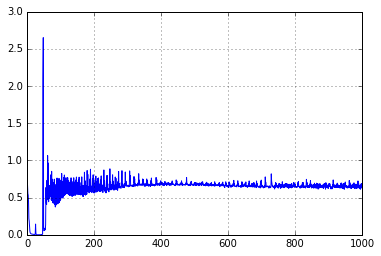

In [16]:
plt.plot(list(range(train_iters)), disc_losses["loss"])
plt.grid()

## Adversarial net losses

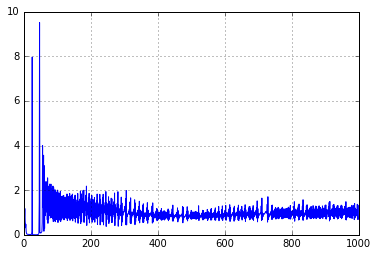

In [17]:
plt.plot(list(range(train_iters)), adv_losses["loss"])
plt.grid()

## An attempt to generate images

In [20]:
noise = np.random.uniform(-1.0, 1.0, size=[10, gen_noise_dim])
fake_images = gennet.predict(noise)
# draw_image(fake_image.reshape((28, 28)))

In [ ]:
fake_images.shape